# WSO - PROD Retention Score - Less features
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* June 7, 2022

## Hypothesis


## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [3]:
lkupclientid = 14 # WSO
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrWSO].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(12539, 53)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12539 entries, 0 to 12538
Data columns (total 53 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            12539 non-null  int64  
 1   dimCustomerMasterId     12539 non-null  int64  
 2   year                    12539 non-null  int64  
 3   productGrouping         12539 non-null  object 
 4   totalSpent              12539 non-null  float64
 5   recentDate              12539 non-null  object 
 6   attendancePercent       12539 non-null  float64
 7   renewedBeforeDays       12539 non-null  int64  
 8   isBuyer                 12539 non-null  object 
 9   source_tenure           12539 non-null  int64  
 10  tenure                  12539 non-null  int64  
 11  distToVenue             12539 non-null  float64
 12  totalGames              12539 non-null  int64  
 13  recency                 12539 non-null  int64  
 14  missed_games_1          12539 non-null

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
                "dimCustomerMasterId",
                "attendancePercent",
                "totalSpent",
                "source_tenure",
                "renewedBeforeDays",
                "isNextYear_Buyer",
                "productGrouping",
                "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (8621, 8)
Unseen Data For Predictions: (1521, 8)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
                "attendancePercent",
                "totalSpent",
                "source_tenure",
                "renewedBeforeDays",
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7302,0.7996,0.7005,0.7075,0.7038,0.4561,0.4563,0.2570


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7244,0.7965,0.6756,0.7094,0.6921,0.4430,0.4434
1,0.7353,0.8144,0.7292,0.7040,0.7164,0.4684,0.4687
2,0.7422,0.8157,0.7194,0.7173,0.7183,0.4806,0.4806
3,0.7285,0.7963,0.7134,0.6988,0.7061,0.4539,0.4540
4,0.7353,0.8087,0.7075,0.7117,0.7096,0.4665,0.4665
5,0.7299,0.7914,0.6925,0.7095,0.7009,0.4547,0.4548
6,0.7449,0.8118,0.6836,0.7387,0.7101,0.4829,0.4841
7,0.6954,0.7739,0.6866,0.6609,0.6735,0.3882,0.3884
8,0.7500,0.8124,0.7134,0.7331,0.7231,0.4953,0.4955
9,0.7158,0.7743,0.6836,0.6918,0.6877,0.4271,0.4271


### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(2397, 53)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,source_tenure,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
10142,14,326095979,2021,Mini Plan,271.00,2021-08-19,0.500000,217,TRUE,1095,...,0,0,0.0,1,16,0,0,0,0.6609,0.3391
10143,14,326096618,2021,Mini Plan,1072.00,2021-08-19,0.750000,74,TRUE,1095,...,0,0,0.0,1,16,0,0,0,0.9338,0.0662
10144,14,326096887,2021,Mini Plan,542.00,2021-08-19,0.750000,217,TRUE,1460,...,0,0,0.0,1,16,0,0,0,0.6509,0.3491
10145,14,342654559,2021,Mini Plan,112.02,2021-08-14,0.333333,72,TRUE,1095,...,0,0,0.0,1,16,0,0,0,0.9274,0.0726
10146,14,342669176,2021,Mini Plan,784.00,2021-08-17,0.875000,73,TRUE,1825,...,0,0,0.0,1,16,0,0,0,0.9214,0.0786


In [11]:
new_predictions["Label"].value_counts()

0    2068
1     329
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    1425
(0.2, 0.4]        459
(0.4, 0.6]        315
(0.6, 0.8]        198
(0.8, 1.0]          0
Name: Score_1, dtype: int64

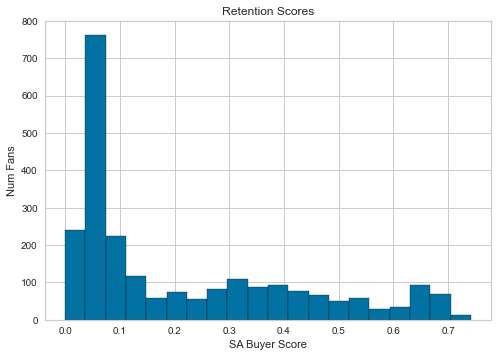

In [13]:
plt.hist(new_predictions["Score_1"], bins=20, edgecolor='black')
plt.title("Retention Scores")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.show()

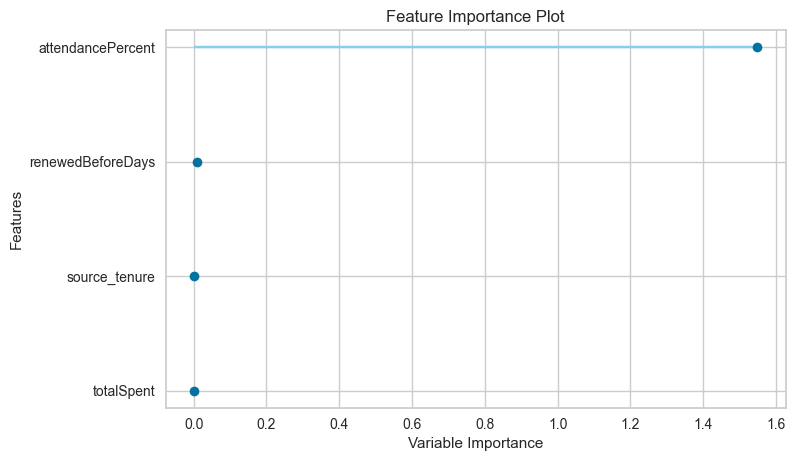

In [14]:
plot_model(best_model, plot='feature')

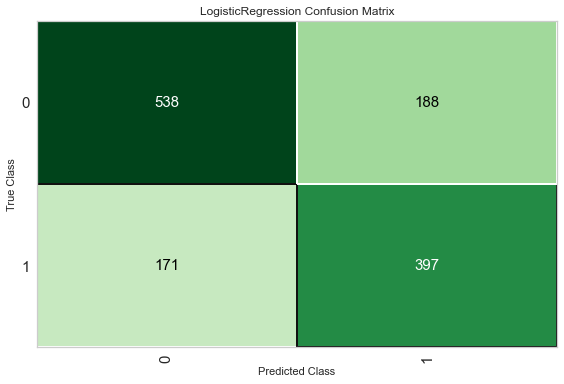

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above